# Iris classification with FermionicPQCKernel


<table class="nt-notebook-buttons" align="center">
  <td>
    <a target="_blank" href="https://MatchCake.github.io/MatchCake/"><img src="https://github.com/MatchCake/MatchCake/blob/main/images/logo/logo_32px.png?raw=true" width=32px height=32px  />Documentation</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/MatchCake/MatchCake/blob/main/tutorials/iris_classification.ipynb"><img src="https://github.com/MatchCake/MatchCake/blob/main/images/logo/colab_logo_32px.png?raw=true" width=32px height=32px  />Run in Google Colab</a>
</td>
  <td>
    <a target="_blank" href="https://github.com/MatchCake/MatchCake/blob/main/tutorials/iris_classification.ipynb"><img src="https://github.githubassets.com/images/modules/logos_page/GitHub-Mark.png" width=32px height=32px />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/MatchCake/MatchCake/blob/main/tutorials/iris_classification.ipynb"><img src="https://github.com/MatchCake/MatchCake/blob/main/images/logo/download_logo_32px.png?raw=true" width=32px height=32px />Download notebook</a>
  </td>
</table>

In this example, you will see how to do data classification with the `FermionicPQCKernel` from the MatchCake package. The `FermionicPQCKernel` is a kernel that encode the data into fermionic rotations gates before using fSWAP gate to entangle the nearest neighbours qubits together.

# Setup

You can now install the dependencies by running the following commands:

In [1]:
#@title Install dependencies {display-mode: "form"}

RunningInCOLAB = 'google.colab' in str(get_ipython()) if hasattr(__builtins__,'__IPYTHON__') else False

if RunningInCOLAB:
    !pip install matchcake

# Imports

First, we need to import the necessary packages. We will use the `datasets` module from `sklearn` to load the Iris dataset, the `train_test_split` function to split the dataset into training and testing sets, and the `MinMaxScaler` to scale the data and others.

In [18]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import seaborn as sns
from matchcake.ml.kernels import FermionicPQCKernel
from matchcake.ml.visualisation import ClassificationVisualizer
from matchcake.ml.kernels.linear_nif_kernel import LinearNIFKernel

# Parameters

We will define our hyperparameters here. We will use 4 qubits to encode the data.

In [3]:
n_qubits = 4

# Load the data

We will load the Iris dataset.

In [4]:
dataset = datasets.load_iris(as_frame=True)
X, y = dataset.data, dataset.target

# Split the data

We will split the data into training and testing sets.

In [5]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Build the SKlearn Pipeline

We will build the model using the `FermionicPQCKernel`.

In [6]:
pipline = Pipeline([
    ('scaler', MinMaxScaler(feature_range=(0, 1))),
    ('kernel', FermionicPQCKernel(n_qubits=n_qubits, rotations="X,Z").freeze()),
    ('classifier', SVC(kernel='precomputed')),
])

As for comparison, we can compare the `FermionicPQCKernel` with the `LinearNIFKernel` which use a linear layer to generate fermionic parameters.

In [7]:
linear_pipline = Pipeline([
    ('scaler', MinMaxScaler(feature_range=(0, 1))),
    ('kernel', LinearNIFKernel(n_qubits=n_qubits)),
    ('classifier', SVC(kernel='precomputed')),
])

We also build a pipeline with the aligned version of the `LinearNIFKernel` to see how alignment can help to improve the performance.

In [8]:
aligned_linear_pipline = Pipeline([
    ('scaler', MinMaxScaler(feature_range=(0, 1))),
    ('kernel', LinearNIFKernel(n_qubits=n_qubits, alignment=True)),
    ('classifier', SVC(kernel='precomputed')),
])

# Train the model

We will train the model using the training data.

In [9]:
pipline.fit(x_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('kernel', FermionicPQCKernel(n_qubits=4, rotations='X,Z')),
                ('classifier', SVC(kernel='precomputed'))])

In [10]:
linear_pipline.fit(x_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('kernel', LinearNIFKernel(n_qubits=4)),
                ('classifier', SVC(kernel='precomputed'))])

In [11]:
aligned_linear_pipline.fit(x_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('kernel', LinearNIFKernel(alignment=True, n_qubits=4)),
                ('classifier', SVC(kernel='precomputed'))])

# Evaluate the Pipeline

We will evaluate the pipeline using the testing data.

In [12]:
pipline["kernel"].freeze()
test_accuracy = pipline.score(x_test, y_test)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

Test accuracy: 90.00%


In [13]:
linear_pipline["kernel"].freeze()
test_accuracy = linear_pipline.score(x_test, y_test)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

Test accuracy: 86.67%


In [14]:
aligned_linear_pipline["kernel"].freeze()
test_accuracy = aligned_linear_pipline.score(x_test, y_test)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

Test accuracy: 96.67%


First we see that the test accuracy with the aligned kernel is better than wihtout alignment, which shows that the alignment can help to improve the performance of the model. Another thing we can do is to look at the evolution of the alignment through the optmization process.

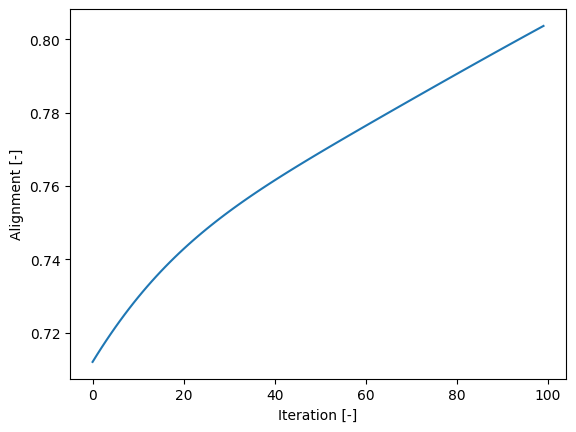

In [21]:
ax = sns.lineplot(aligned_linear_pipline["kernel"].opt_.history)
ax.set_xlabel("Iteration [-]")
ax.set_ylabel("Alignment [-]")
display(ax.figure)

# Visualize the results

We can visualize the decision boundaries of the model.

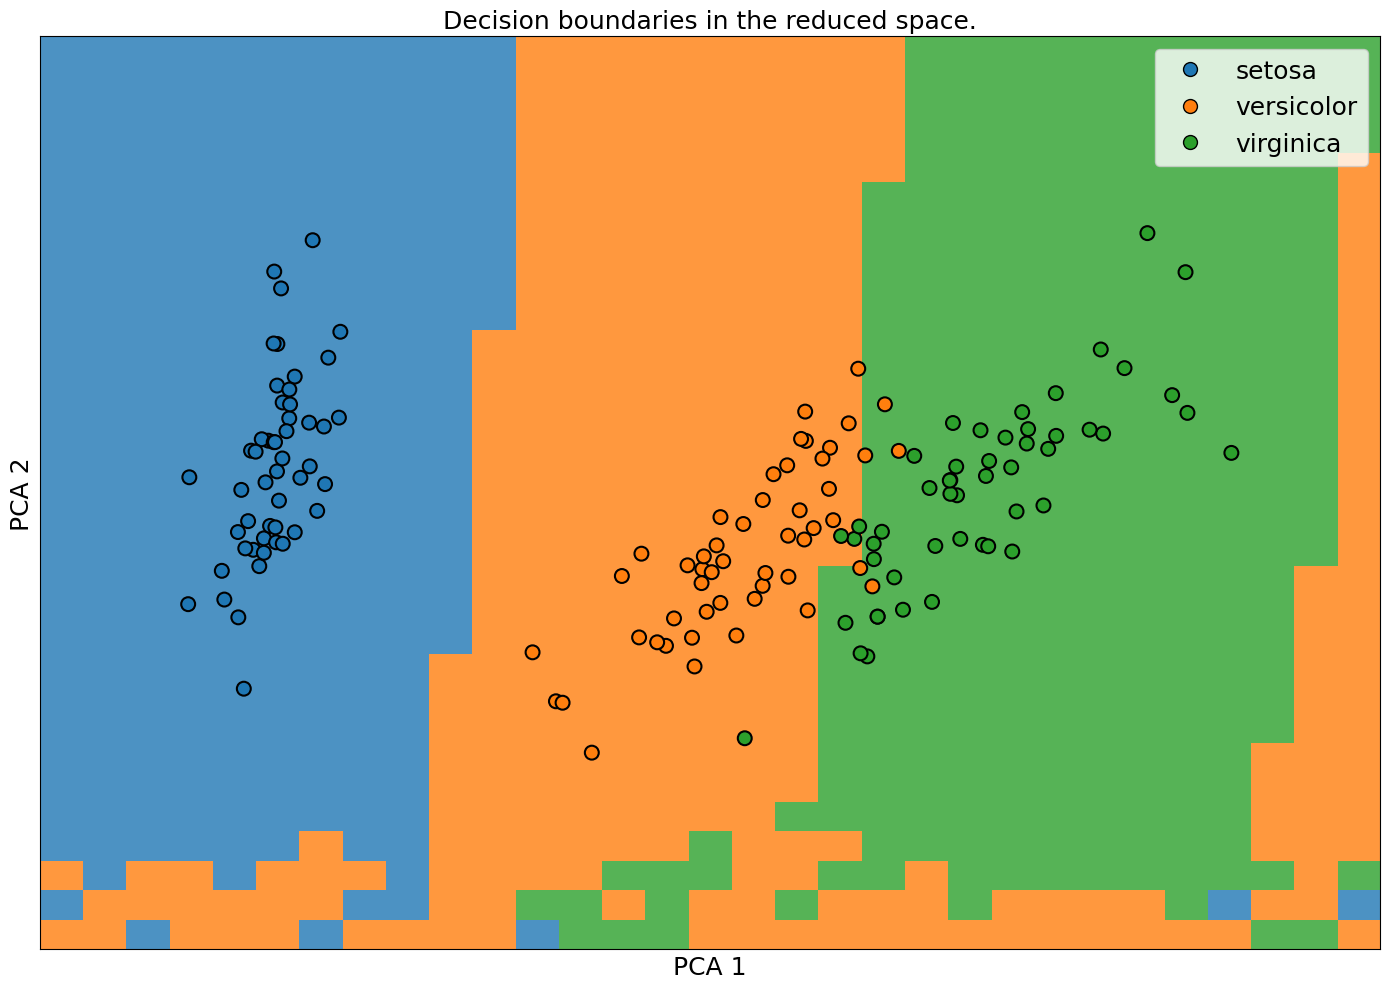

In [15]:
viz = ClassificationVisualizer(x=X, n_pts=1_000)
fig, ax, y_pred = viz.plot_2d_decision_boundaries(
    model=pipline, y=y, legend_labels=getattr(dataset, "target_names", None), show=True
)

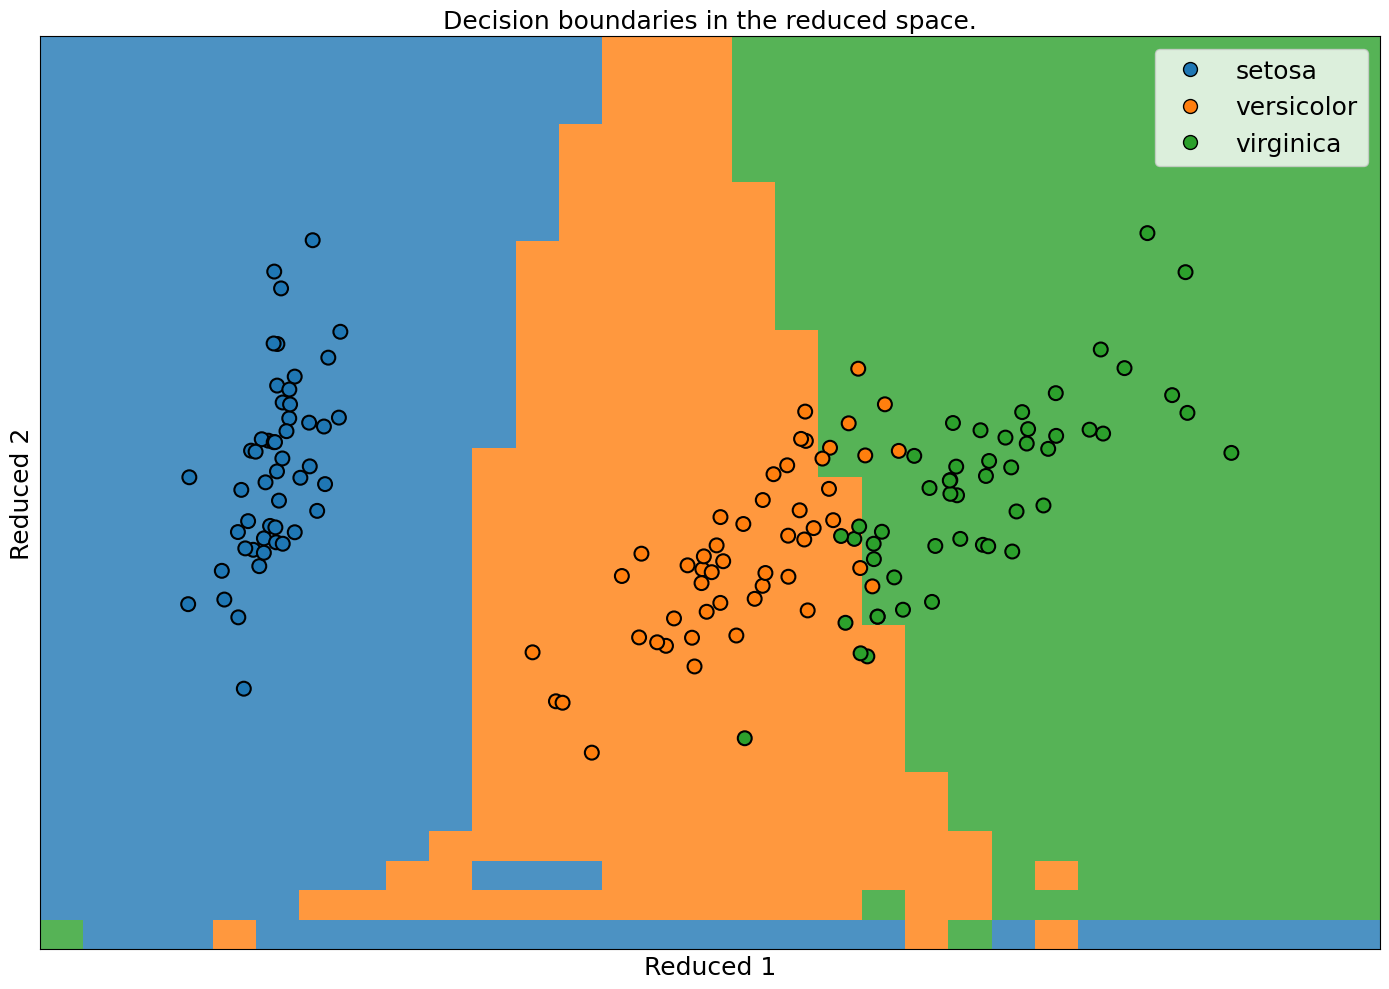

In [16]:
fig, ax, y_pred = viz.plot_2d_decision_boundaries(
    model=linear_pipline, y=y, legend_labels=getattr(dataset, "target_names", None), show=True
)

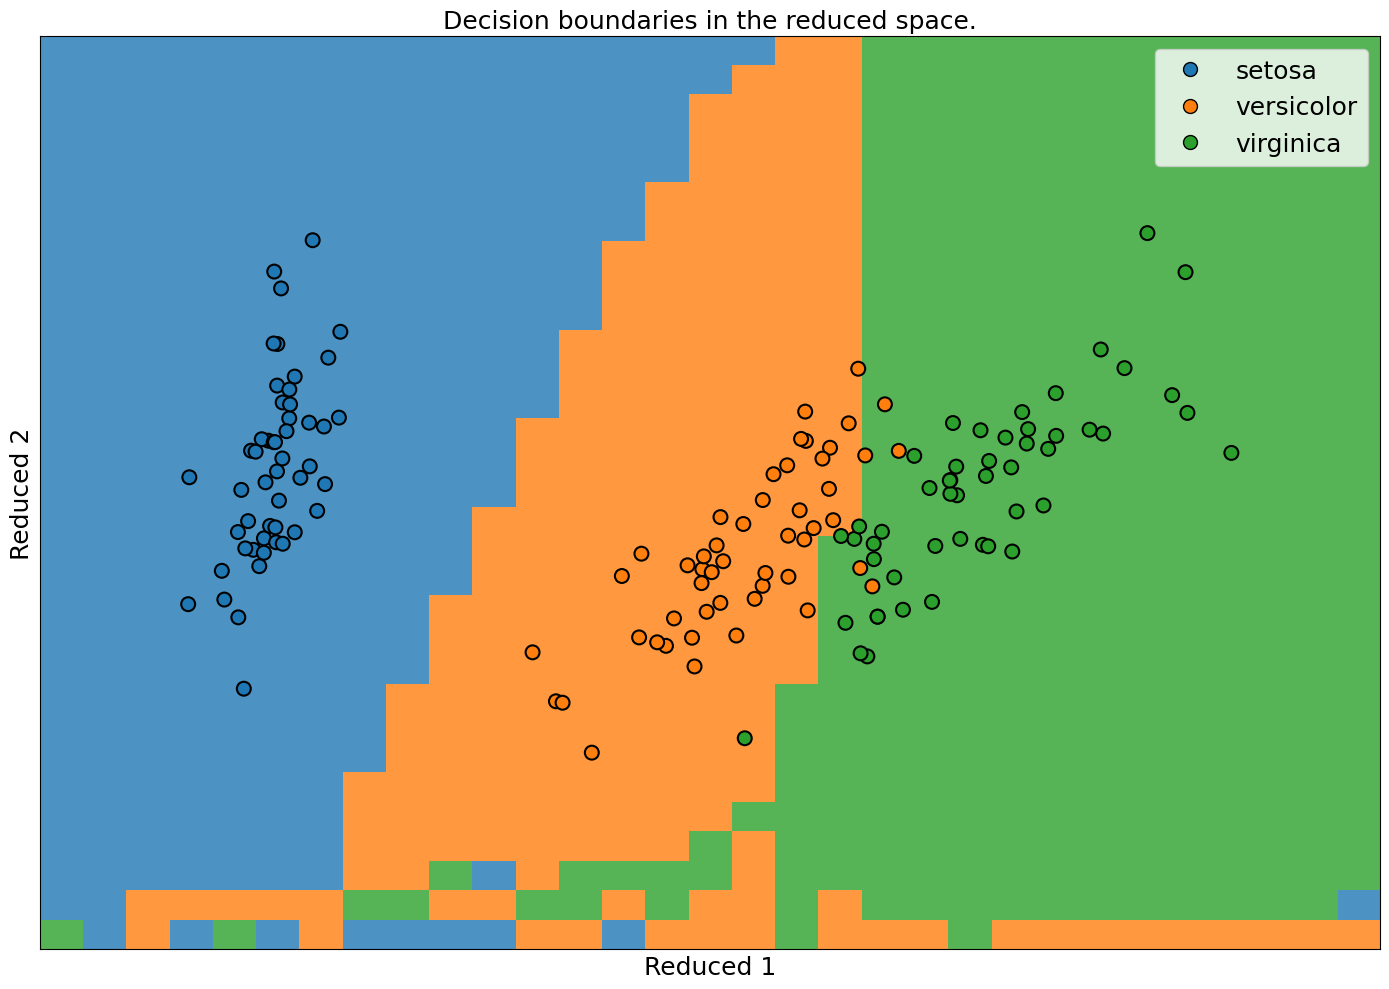

In [17]:
fig, ax, y_pred = viz.plot_2d_decision_boundaries(
    model=aligned_linear_pipline, y=y, legend_labels=getattr(dataset, "target_names", None), show=True
)

----------